In [35]:
import dolfin
import numpy as np # mainly for storing data
import fenics_plotly # for plotting finite element stuff
import matplotlib.pyplot as plt # for plotting traces

fenics_plotly.set_renderer("iframe") # renderer needed for jupyter notebooks

# Force quadrature degree 
deg = 2
dolfin.parameters["form_compiler"]["quadrature_degree"]=deg

In [36]:
num_timesteps = 10
pk2_stress_history = np.nan*np.ones(num_timesteps) # initializing with NaN so we don't have false zeros
eff_history = np.nan*np.ones(num_timesteps)
counter = 0

In [37]:
# Let's go ahead and define a function that will calculate the PK2 stress in the fiber direction
def calculate_pk2_stress(W_passive, E_comp, lcs):
    
    """ Return 2nd Piola Kirchhoff stress in fiber direction.
    
    :W_passive: strain energy function defined in terms of local coordinates
    :E_comp: list, Green-Lagrange strain transformed into local coordinates
    :lcs: list, local coordinate system vector functions
    
    return: scalar, stress in fiber direction
    """
    
    # These will be vector valued functions on the mesh (functions on the finite element function space used to define our coordinate system)
    f0 = lcs[0]
    s0 = lcs[1]
    n0 = lcs[2]
    
    # List of components of E tensor in local coordinates (coincident with the cartesian coordinate system in this example)
    Eff = E_comp[0]
    Efs = E_comp[1]
    Efn = E_comp[2]
    Esf = E_comp[3]
    Ess = E_comp[4]
    Esn = E_comp[5]
    Enf = E_comp[6]
    Ens = E_comp[7]
    Enn = E_comp[8]
    
    # doing this differentiation separately for each tensor component
    # Later, you will see that the components of E are declared as dolfin 'variable' types. This must  be the case if differentiation is to be done with respect to 
    # a variable. If not, the function either throws an error, or returns zero. 
    
    # It could probably be that one could create the tensor E using the 'dolfin.as_tensor()' method, and declare this tensor as a dolfin variable. Then maybe
    # you could just do 'S_local = dolfin.diff(W_passive, E), but I have not tested this. Through troubleshooting (there was a time when the PK2 stress tensor 
    # was not symmetric, which is an error!) at some point I decided this was an explicit way to get the correct tensor.
    S_local = (dolfin.diff(W_passive,Eff)*dolfin.outer(f0,f0) + dolfin.diff(W_passive,Efs)*dolfin.outer(f0,s0) 
            + dolfin.diff(W_passive,Efn)*dolfin.outer(f0,n0,) + dolfin.diff(W_passive,Esf)*dolfin.outer(s0,f0) 
            + dolfin.diff(W_passive,Ess)*dolfin.outer(s0,s0) + dolfin.diff(W_passive,Esn)*dolfin.outer(s0,n0) 
            + dolfin.diff(W_passive,Enf)*dolfin.outer(n0,f0) + dolfin.diff(W_passive,Ens)*dolfin.outer(n0,s0) 
            + dolfin.diff(W_passive,Enn)*dolfin.outer(n0,n0))
    
    # S_local*f0 gives the traction vector, the inner product with f0 gets the component of stress in the fiber direction
    S_f = dolfin.inner(f0,S_local*f0) #-> this returns a ufl object
    
    # When trying to actually access values, we need to associate S_f with a finite element function space, so we need to either project
    # or interpolate to one. Too many projection calls may slow the code down. I think it is the case that the interpolate method cannot 
    # handle ufl objects and expects a dolfin object, so I usually default to projection
    pk2_stress_fiber = dolfin.project(S_f,dolfin.FunctionSpace(mesh,"DG",1)).vector().get_local()[0] #homogeneous, just picking first value
    
    return pk2_stress_fiber

In [38]:
mesh = dolfin.UnitCubeMesh(1,1,1)

In [39]:
# Set up elements and spaces for the problem
# For displacement
Velem = dolfin.VectorElement("CG", mesh.ufl_cell(), 2, quad_scheme="default")
# mesh.ufl_cell() keeps this command generic, will always be 'tetrahedron' unless your mesh is 2D (which would give 'triangle')

# For hydrostatic pressure (enforcing incompressibility), of degree one less than element used for displacement
Qelem = dolfin.FiniteElement("CG", mesh.ufl_cell(), 1, quad_scheme="default")

# Mixed element function space, creating the mixed element inline using Velem and Qelem
W = dolfin.FunctionSpace(mesh, dolfin.MixedElement([Velem, Qelem]))

# For the weak form
w = dolfin.Function(W)
dw = dolfin.TrialFunction(W)
wtest = dolfin.TestFunction(W)

du, dp = dolfin.TrialFunctions(W)
u, p = dolfin.split(w)
v, q = dolfin.TestFunctions(W)

In [40]:
# Let's create a local coordinate system for the cube. 
# Right now, using Velem which has nodes defined for a CG2 element. In MyoFE, we define these at the quadrature points,
# so that when we solve MyoSim and assign active stress information in the f0 direction, there is no mismatch between
# myosim information at integration point i and the vector denoting f0.

# I think just assigning a continuous active stress field using the below V_space works, but there is instability when solving
# for active stress using something like MyoSim using this space. See work by Henrik Finsberg where they assign Ta using a
# space like this
V_space = dolfin.FunctionSpace(mesh,Velem)

f0 = dolfin.Function(V_space) 
s0 = dolfin.Function(V_space) 
n0 = dolfin.Function(V_space) 

for i in np.arange(np.shape(f0.vector())[0]/3.0):
    f0.vector()[3*i] = 1.0   # coincident with x-axis (gives vector (1,0,0) at each degree of freedom)
    s0.vector()[3*i+1] = 1.0 # coincident with y-axis (gives vector (0,1,0))
    n0.vector()[3*i+2] = 1.0 # coincident with z-axis (gives vector (0,0,1))

In [41]:
class Left(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[0]) < tol

class Lower(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[2]) < tol
    
class Back(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[1]) < tol

class Right(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[0] - 1.0) < tol
    
class Top(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[2] - 1.0) < tol
    
    
left  = Left()
lower = Lower()
back = Back()
right = Right()
top = Top()

In [42]:
facetboundaries = dolfin.MeshFunction('size_t', mesh, mesh.topology().dim()-1)
facetboundaries.set_all(0)

N  = dolfin.FacetNormal(mesh)
ds = dolfin.ds(subdomain_data = facetboundaries)
dx = dolfin.dx(mesh,metadata = {"integration_order":2})

left.mark(facetboundaries, 1)
lower.mark(facetboundaries, 2)
back.mark(facetboundaries, 3)
right.mark(facetboundaries, 4)
top.mark(facetboundaries, 5)

In [43]:
u_d = dolfin.Expression(("ud_x"), ud_x = 0.0, degree = 0)

# Constrain left face in x
# W.sub(0) represents displacement (the first element in the above defined MixedElement), so W.sub(0).sub(0) is the 0th (or x) component of displacement
# We are using dolfin.Constant((0.0)) to denote that we want the chosen component of displacement to be zero
# and facetboundaries, 1 tells the method we want this to apply for the facetboundary labeled 1, which is the set of points belonging to the left class above

#bc_left  = dolfin.DirichletBC(W.sub(0).sub(0), dolfin.Constant((0.0)), facetboundaries, 1)
bc_top  = dolfin.DirichletBC(W.sub(0).sub(2), dolfin.Constant((0.0)), facetboundaries, 5)
bc_top2  = dolfin.DirichletBC(W.sub(0).sub(0), u_d, facetboundaries, 5)
# Constrain lower face in z
bc_lower = dolfin.DirichletBC(W.sub(0).sub(2), dolfin.Constant((0.0)), facetboundaries, 2)
bc_lower2 = dolfin.DirichletBC(W.sub(0).sub(0), dolfin.Constant((0.0)), facetboundaries, 2)
# constrain back face in y
bc_back = dolfin.DirichletBC(W.sub(0).sub(1), dolfin.Constant((0.0)), facetboundaries, 3)
# Use a user-defined expression to control displacement at the right face
#bc_right = dolfin.DirichletBC(W.sub(0).sub(0), u_d, facetboundaries, 4)

# Finally, our list of all dirichlet boundary conditions which will be given to our solver later
dirichlet_bcs = [bc_top, bc_top2, bc_lower, bc_lower2, bc_back]

In [44]:
# Some continuum quantities
dim = u.ufl_domain().geometric_dimension()
I = dolfin.Identity(dim)
F = I + dolfin.grad(u)
J = dolfin.det(F) 

# Green-Lagrangian Strain tensor
E = 0.5*(F.T*F - I)

#Now let's set up the weak form
# p is the hydrostatic pressure (lagrange multiplier to enforce incompressibility)
W_incompressible = -p*(J - 1.0)

# Guccione law

# Get strain in terms of local coordinates
Eff = dolfin.variable(dolfin.inner(f0, E*f0))
Ess = dolfin.variable(dolfin.inner(s0, E*s0))
Enn = dolfin.variable(dolfin.inner(n0, E*n0))
Efs = dolfin.variable(dolfin.inner(f0, E*s0))
Efn = dolfin.variable(dolfin.inner(f0, E*n0))
Ens = dolfin.variable(dolfin.inner(n0, E*s0))
Esf = dolfin.variable(dolfin.inner(s0, E*f0))
Esn = dolfin.variable(dolfin.inner(s0, E*n0))
Enf = dolfin.variable(dolfin.inner(n0, E*f0))

# These are put into lists for the function that calculates stress
lcs = [f0, s0, n0]
E_comp = [Eff, Efs, Efn, Esf, Ess, Esn, Enf, Ens, Enn]

# material parameters
c   = 0.26
bf  = 2.0
bx  = 5.58
bfx = 1.627

Q = bf*Eff**2.0 + bx*(Ess**2.0 + Enn**2.0 + Ens**2.0 + Esn**2.0) + bfx*(Efs**2.0 + Esf**2.0 + Efn**2.0 + Enf**2.0)

# Strain energy function
W_passive = (c/2.0)*(dolfin.exp(Q) - 1.0)

F_passive = dolfin.derivative(W_passive, w, wtest)*dx
F_incompressible = dolfin.derivative(W_incompressible, w, wtest)*dx

Ftotal = F_passive + F_incompressible

# Jacobian for linearization
Jac_passive_body = dolfin.derivative(F_passive, w, dw)
Jac_incompressible = dolfin.derivative(F_incompressible, w, dw)

Jac_total = Jac_passive_body + Jac_incompressible  

In [45]:
for i in np.arange(10):
    
    # Increment the displacement of the right face
    u_d.ud_x += 0.02
    
    # Since we gave ud to the boundary DirichletBC method earlier, and we are updating the ud object, we just have to solve our weak form
    dolfin.solve(Ftotal == 0, w, bcs=dirichlet_bcs, J=Jac_total)

    # We also want to track the progression of the pk2 stress in the fiber direction during the displacement
    pk2_stress_history[i] = calculate_pk2_stress(W_passive, E_comp, lcs)
    
    # Let's also save the Green Lagrange strain in the fiber direction
    eff_history[i] = dolfin.project(Eff,dolfin.FunctionSpace(mesh,"CG",1)).vector().get_local()[0]

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.576e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 4.611e-05 (tol = 1.000e-10) r (rel) = 2.926e-04 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.086e-09 (tol = 1.000e-10) r (rel) = 1.324e-08 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1.323e-16 (tol = 1.000e-10) r (rel) = 8.397e-16 (tol = 1.000e-09)
    Newton solver finished in 3 iterations and 3 linear solver iterations.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.576e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 4.561e-05 (tol = 1.000e-10) r (rel) = 2.894e-04 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.976e-09 (tol = 1.000e-10) r (rel) = 1.254e-08 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 9.149e-17 (tol = 1.000e-10) r (rel) = 5.807e-16 (tol = 1.000e-09)
    Newton solver finished in 3 iterations 

Text(0, 0.5, 'PK2 Fiber\n(kPa)')

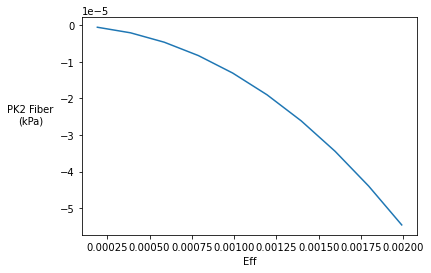

In [46]:
plt.plot(eff_history,pk2_stress_history)
plt.xlabel('Eff')
plt.ylabel('PK2 Fiber\n(kPa)',rotation=0,labelpad=30)

In [47]:
# Let's look at the deformed mesh overlaid on the reference mesh

# Get a copy of the solution
u, p = w.split()

# Interpolate the solution onto a FE space
u_int = dolfin.interpolate(u, dolfin.VectorFunctionSpace(mesh, "CG", 2))

# Plot
fig = fenics_plotly.plot(mesh,color="blue",opacity = 0.5,show=False)

# Move mesh according to u_int for plotting purposes
dolfin.ALE.move(mesh,u_int)
fig.add_plot(fenics_plotly.plot(mesh, color="red", opacity = 0.5, show=False))
fig.show()